# 2.C. Cleaning and Engineering -- Reviews

We'll take time in this notebook to clean our review text. While some additional work was done here as it relates to extracting adjectives from these reviews and leveraging said adjectives for review clustering, this was not leveraged for the final recommender. Please see the **(ARCHIVED)** section of this notebook if you are curious.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import requests
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import lyricsgenius
import re
import sys
import spotipy
import spotipy.util as util
from sklearn.compose import ColumnTransformer, make_column_transformer
from pyjarowinkler import distance
import nltk

import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import requests
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from gensim import corpora, models



In [2]:
review_df = pd.read_csv('./combining/albumdata/allreviews_concat.csv')

In [3]:
review_df.columns

Index(['artist_album_clean_key', 'artist', 'album', 'rr_review',
       'pitch_review', 'needle_review', 'combined_reviews', 'pitch_score',
       'pitch_date', 'needle_score'],
      dtype='object')

In [4]:
review_df = review_df[review_df['combined_reviews'].str.contains(' rap ')]

### Cleaning

In [5]:
#filter out stopwords, filtering out financial lexicon (?)
from nltk.corpus import stopwords
stop = stopwords.words('english')
custom_words = ['hi', 'hey', 'anthony', 'fantano', 'I', 'i', 'my', 'me', 'am', 'im', 'hiphop', 'hop', 'hip', 'lyrics', 'rap', 'rapping', 'rapper']

In [6]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"isn\'t", "is not", phrase)
    phrase = re.sub(r"ain\'t", "is not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub("in' " , 'ing ', phrase)
    phrase = re.sub(" tha " , ' the ', phrase)
    phrase = re.sub(" da " , ' the ', phrase)
    phrase = re.sub(" dat " , ' that ', phrase)
    phrase = re.sub("in’ " , 'ing ', phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
#Remove quotes of lyrics
review_df['combined_reviews_clean'] = review_df['combined_reviews'].str.replace('".*"'," ")
review_df['combined_reviews_clean'] = review_df['combined_reviews_clean'].str.replace('“.*”'," ")

#remove everything with quotes, remove new lines

review_df['combined_reviews_clean'] = review_df['combined_reviews_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_words)]))['combined_reviews_clean'] = review_df['combined_reviews_clean'].str.replace('|', '')
review_df['combined_reviews_clean'] = review_df['combined_reviews_clean'].str.replace('\n', ' ')
review_df['combined_reviews_clean'] = review_df['combined_reviews_clean'].str.replace('[^a-zA-Z ]+', ' ')
review_df['combined_reviews_clean'] = review_df['combined_reviews_clean'].str.replace('([ ]{2,})', ' ', regex = True)
review_df['combined_reviews_clean'] = review_df['combined_reviews_clean'].str.lower()
review_df['combined_reviews_clean'] = review_df['combined_reviews_clean'].apply(decontracted)

In [8]:
artist_strip = list(review_df.artist.unique())

In [9]:
review_df['combined_reviews_clean'] = review_df['combined_reviews_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
review_df['combined_reviews_clean'] = review_df['combined_reviews_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_words)]))

In [10]:
review_df['pitch_score'].fillna(review_df['pitch_score'].dropna().mean(), inplace=True)
review_df['needle_score'].fillna(review_df['needle_score'].dropna().mean(), inplace=True)

In [32]:
review_df[['artist_album_clean_key', 'artist', 'album', 'combined_reviews_clean', 'pitch_date', 'pitch_score', 'needle_score']].to_csv('./combining/albumdata/review_data_for_recommender.csv', index=False)

## (ARCHIVED) Grabbing Adjectives

In [938]:
import spacy
from spacy import displacy
from collections import Counter
from spacy.lang.en.examples import sentences 
import en_core_web_sm#### Irrelevant Words

In [939]:
nlp = en_core_web_sm.load()

In [991]:
ex = " ".join(review_df['combined_reviews'][30:34])

In [1042]:
review_df.iloc[43:45]

,artist_album_clean_key,artist,album,rr_review,pitch_review,needle_review,combined_reviews,pitch_score,pitch_date,needle_score,combined_reviews_clean
43,a boogie wit da hoodie|hoodie szn,a boogie wit da hoodie,hoodie szn,NaN,Despite the typical bloated-album problems lik...,NaN,|Despite the typical bloated-album problems li...,6.8,2018,NaN,despite typical bloated album problems like pa...
44,a boogie wit da hoodie|international artist,a boogie wit da hoodie,international artist,NaN,The latest project from the Bronx rapper enlis...,NaN,|The latest project from the Bronx rapper enli...,6.3,2018,NaN,latest project bronx enlists musicians across ...


In [1014]:
nlp = en_core_web_sm.load()
doc = nlp(ex)
results = [(X.text, X.label_) for X in doc.ents]

In [171]:
from textblob import TextBlob
import random
import sys

In [318]:
blob = TextBlob(ex)

In [300]:
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

In [335]:
def adjectives(review):
    
    blob = TextBlob(review)
    adj_for_artist = []
    
    for word, pos in blob.tags:
        if((pos =='JJ') & (syllable_count(word) > 2)):
            adj_for_artist.append(word)
            
    return(",".join(adj_for_artist))


In [371]:
review_df['adjectives'] = review_df['combined_reviews_clean'].apply(adjectives)

In [413]:
# counter = 0
# for word, pos in blob.tags:
#         counter += 1
#             print(word)
#             print(counter)

In [1016]:
blob = TextBlob(" ".join(review_df['combined_reviews_clean'][30:34]))
adj_for_artist = []

counter = 0   
for word, pos in blob.tags:
    counter+=1
    if((pos =='NN') & (syllable_count(word) > 1)):
        for word_search, pos_search in blob.tags[counter-10:counter+10]:
            if((word_search == 'album') | (word_search == 'artist')):
                adj_for_artist.append(word)

In [1017]:
adj_for_artist

['amorality',
 'money',
 'something',
 'concept',
 'album',
 'landscape',
 'opposition',
 'fearless',
 'graduation',
 'album',
 'blatant',
 'rehash',
 'bottom',
 'sequel',
 'audience',
 'duration',
 'dexterity',
 'interest',
 'album',
 'misstep',
 'album',
 'album',
 'evidence',
 'evidence',
 'possession',
 'possession',
 'album',
 'album',
 'persona',
 'album',
 'anticipation',
 'jadakiss',
 'release',
 'album']

In [996]:
adjectives(" ".join(review_df['combined_reviews_clean'][30:34]))

'musical,machiavellian,entertaining,practical,revisionist,fearlessness,connecticut,impressive,intoxicate,clinical,argument,transactional,allegory,remorseless,repetitive,machiavellian,auxiliary,amusing,vulnerable,underperformed,transparent,personal,approachable,inelegant,primitive,dynamic,indelible,original,bountiful,instrumental,reflective,useless,dangerous,conspicuous,several,reclusive,pathetic,insular,derrideian,derrideian,feminist,dominant,unquenchable,narrative,political,misogynistic,destructive,bravado,charisma,excellent,imagery,necessary,inhabited,mechanical,paralyzed,visceral,addictive,experimental,irresistible,infectious,elusive,prerequisite,potential,godfatherish,invigorate,ironic,documentary,gigantic,narrative,valentine,powerful'

In [862]:
adj_for_artist

['album', 'final', 'relatable']

In [758]:
blob.tags

[('the', 'DT'),
 ('last', 'JJ'),
 ('chainz', 'NN'),
 ('album', 'NN'),
 ('was', 'VBD'),
 ('so', 'RB'),
 ('bad', 'JJ'),
 ('it', 'PRP'),
 ('had', 'VBD'),
 ('people', 'NNS'),
 ('questioning', 'VBG'),
 ('whether', 'IN'),
 ('english', 'NN'),
 ('was', 'VBD'),
 ('his', 'PRP$'),
 ('first', 'JJ'),
 ('language', 'NN'),
 ('as', 'IN'),
 ('i', 'JJ'),
 ('wrote', 'VBD'),
 ('possibly', 'RB'),
 ('the', 'DT'),
 ('harshest', 'JJS'),
 ('review', 'NN'),
 ('of', 'IN'),
 ('all', 'DT'),
 ('slicing', 'VBG'),
 ('it', 'PRP'),
 ('to', 'TO'),
 ('shreds', 'VB'),
 ('with', 'IN'),
 ('my', 'PRP$'),
 ('chainzaw', 'NN'),
 ('it', 'PRP'),
 ('delights', 'VBZ'),
 ('me', 'PRP'),
 ('to', 'TO'),
 ('say', 'VB'),
 ('that', 'IN'),
 ('his', 'PRP$'),
 ('follow', 'NN'),
 ('up', 'RB'),
 ('is', 'VBZ'),
 ('much', 'RB'),
 ('much', 'JJ'),
 ('better', 'JJR'),
 ('b', 'NN'),
 ('o', 'IN'),
 ('a', 'DT'),
 ('t', 'NN'),
 ('s', 'NN'),
 ('ii', 'NN'),
 ('is', 'VBZ'),
 ('an', 'DT'),
 ('album', 'NN'),
 ('that', 'WDT'),
 ('feels', 'VBZ'),
 ('happy', '

# (Archived) -- Adjective Clustering

### Trying a Model

In [642]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000,
                             min_df = 5,
                             max_df = 0.30,) 

### Cvec

In [643]:
cvec = vectorizer.fit(review_df['adjectives'].str.replace(",", " "))

In [644]:
feature_names = cvec.get_feature_names()

In [645]:
bag_of_words = cvec.transform(review_df['adjectives'].str.replace(",", " "))

In [646]:
df_bag_of_words = pd.DataFrame(bag_of_words.todense(), columns=feature_names)

In [404]:
review_df_for_bow = review_df.copy()

In [405]:
review_df_for_bow = review_df_for_bow.reset_index()

In [623]:
df_bag_of_words.shape

(3427, 4343)

In [621]:
bow_df = pd.concat([review_df[['artist', 'album']],df_bag_of_words], axis=1)

### Tfidf --> Clustering

In [838]:
tfidf = TfidfVectorizer(
    min_df = 6,
    max_features = 2000,
    stop_words = 'english'
)
tfidf.fit(review_df['adjectives'].str.replace(",", " "))
text = tfidf.transform(review_df['adjectives'].str.replace(",", " "))

In [839]:
text.shape

(3427, 947)

### PCA --> Clustering

In [840]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = text.todense()
ss = StandardScaler()

X_sc = ss.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X_sc)
X_pca = pca.transform(X_sc)

### Trying a Model


In [841]:
print(X_pca)
print(len(X_pca))

[[ 1.35087618  8.8912173 ]
 [ 1.58479604  6.07862445]
 [-1.05730108 -0.99342583]
 ...
 [-1.90239126 -0.61040876]
 [-0.87862814 -0.97312802]
 [-0.65923634 -2.40477904]]
3427


In [842]:
from sklearn.cluster import KMeans, DBSCAN

In [848]:
dbscan = DBSCAN(eps=2.3, min_samples=100)
dbscan.fit(X_pca);

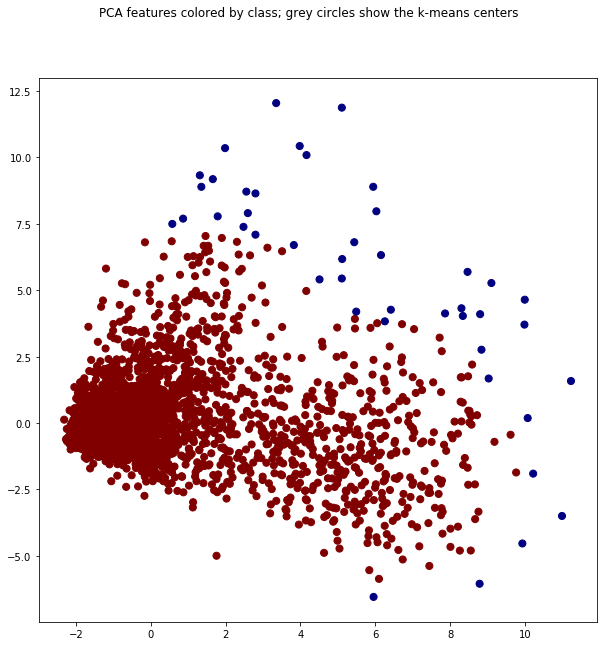

In [849]:
plt.figure(figsize=(10,10))
plt.suptitle('PCA features colored by class; grey circles show the k-means centers');
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan.labels_, s=50, cmap='jet');


In [850]:
silhouette_score(X_sc, dbscan.labels_)

0.2906368062967391

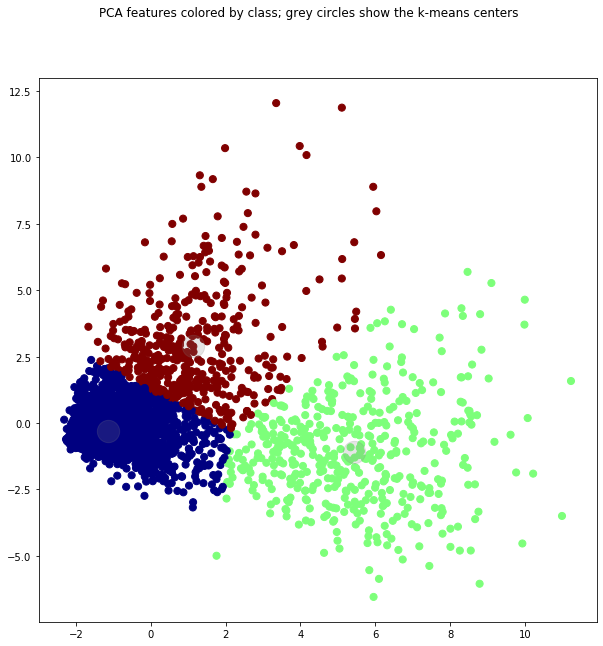

In [846]:
km_model = KMeans(n_clusters=3, max_iter=100, n_init=2, random_state=0)

# K-means (from number of features in input matrix to n_clusters)
km_model.fit(X_pca)
df_centers = pd.DataFrame(km_model.cluster_centers_, columns=['x', 'y'])

plt.figure(figsize=(10,10))
plt.suptitle('PCA features colored by class; grey circles show the k-means centers')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km_model.labels_, s=50, cmap='jet')
plt.scatter(df_centers['x'], df_centers['y'], c='grey', s=500, alpha=0.2);


In [847]:
silhouette_score(X_sc, km_model.labels_)

0.14362381325521464

In [714]:
pd.DataFrame(X_pca)[pd.DataFrame(X_pca)[0] < -30]

,0,1
261,-40.945879,28.975792
481,-42.735242,42.820049
1022,-32.436198,6.960229


In [741]:
pd.DataFrame(pd.DataFrame(X, columns =tfidf.get_feature_names()).iloc[481] * pca.components_[0]).sort_values(by=481)[:20]

,481
funereal,-0.123947
evolved,-0.085998
disliked,-0.083564
eponymous,-0.080970
elegiac,-0.054173
revival,-0.045145
abandoned,-0.000000
populist,0.000000
populated,0.000000
ponderous,0.000000


In [720]:
review_df.iloc[481]

artist_album_clean_key                                       eminem|revival
artist                                                               eminem
album                                                               revival
rr_review                                                               NaN
pitch_review              On his overtly political ninth studio LP, Emin...
needle_review             Hey, everyone. Fresh Orange here, The Internet...
combined_reviews          |On his overtly political ninth studio LP, Emi...
combined_reviews_clean    on his overtly political ninth studio lp emine...
rr_pitch_reviews_clean    on his overtly political ninth studio lp emine...
adjectives                political,eminem,aesthetic,disturbing,catharti...
Name: 1322, dtype: object

In [721]:
pd.DataFrame(X_pca)[pd.DataFrame(X_pca)[0] > 30]

,0,1
645,46.088291,53.810116


In [739]:
review_df.iloc[645]

artist_album_clean_key                           ice cube|death certificate
artist                                                             ice cube
album                                                     death certificate
rr_review                  The inevitable passing of time has seriously ...
pitch_review              Death Certificate is Ice Cube’s most important...
needle_review                                                           NaN
combined_reviews           The inevitable passing of time has seriously ...
combined_reviews_clean     the inevitable passing of time has seriously ...
rr_pitch_reviews_clean     the inevitable passing of time has seriously ...
adjectives                inevitable,lyrical,philosophical,relevant,init...
Name: 1795, dtype: object

In [743]:
pd.DataFrame(pd.DataFrame(X, columns =tfidf.get_feature_names()).iloc[645] * pca.components_[0]).sort_values(by=645)[:20]

,645
abandoned,-0.0
pharmaceutical,0.0
photoshopped,0.0
pillowy,0.0
plainspoken,0.0
platitudinous,-0.0
platonic,0.0
pokemon,-0.0
polarized,0.0
ponderous,0.0


In [716]:
pca.components_[0]

array([-3.17725823e-02, -1.23871834e-02, -1.22834317e-03, -6.39562693e-03,
        1.28850991e-02,  1.02289344e-03,  3.93887125e-04,  1.54755832e-03,
        6.02119574e-04,  2.54178267e-04,  1.50561090e-03, -4.10509775e-03,
       -1.56665565e-02,  1.21394007e-03,  7.47177041e-04,  6.93455395e-02,
       -3.20589746e-03,  1.00381955e-03,  3.52203126e-04,  7.47677333e-03,
        3.48881711e-03, -1.40766942e-02,  5.35548771e-03,  1.08046634e-02,
        4.06333158e-04, -2.28422939e-03,  1.03005692e-03,  9.22036825e-02,
        9.82621850e-04,  7.58905606e-04,  6.40986952e-03,  3.49148006e-04,
       -8.67655329e-04, -2.11984964e-03, -1.28125451e-02, -8.73263339e-02,
        3.59811185e-04, -1.58526799e-02,  5.69058339e-04,  2.29791818e-03,
        4.53620599e-04, -3.19812674e-04, -3.04146050e-02,  3.66975471e-04,
        5.20327604e-03,  3.48125113e-03,  3.66720010e-04,  3.83194369e-04,
        4.45356830e-04,  3.84419968e-04, -4.30398241e-04, -7.59401444e-03,
       -1.20901277e-03,  

In [710]:
from sklearn.metrics import silhouette_score
silhouette_score(X_sc, km_model.labels_)

0.6390102789205837

Attempting Word2Vec

In [1067]:
model = Word2Vec(topic_docs, size=150, window=10, min_count=2, workers=10)
model.train(topic_docs,total_examples=len(topic_docs),epochs=10)

(354638, 437130)

In [1070]:

w1 = "tekashi"
model.wv.most_similar(positive=w1, topn=100)

[('self', 0.9999312162399292),
 ('human', 0.9999211430549622),
 ('book', 0.9999133348464966),
 ('curtis', 0.9999017119407654),
 ('c', 0.9998987317085266),
 ('prison', 0.999898374080658),
 ('mountain', 0.9998928308486938),
 ('native', 0.9998922944068909),
 ('several', 0.9998917579650879),
 ('purple', 0.9998912811279297),
 ('million', 0.9998912811279297),
 ('must', 0.9998904466629028),
 ('late', 0.9998847246170044),
 ('ix', 0.9998838305473328),
 ('real', 0.9998807311058044),
 ('labor', 0.9998784065246582),
 ('duo', 0.9998767375946045),
 ('form', 0.9998764991760254),
 ('party', 0.9998763799667358),
 ('soundtrack', 0.999871551990509),
 ('center', 0.9998703002929688),
 ('former', 0.999869167804718),
 ('ine', 0.9998689293861389),
 ('state', 0.9998688697814941),
 ('clinton', 0.9998688101768494),
 ('j', 0.9998663067817688),
 ('ghost', 0.9998653531074524),
 ('legal', 0.9998636841773987),
 ('process', 0.9998611807823181),
 ('ultimately', 0.9998586773872375),
 ('accepted', 0.999857485294342),
 ('

In [914]:
model.wv.similarity(w1="fast",w2="busta")

0.24455144